In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

import pandas as pd
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [2]:
df = pd.read_csv('prepared_abuse_data.csv')
df = df[df['annotation']==2]

In [3]:
df

,tweet id,annotation,tweet text,tweet user id,tweet user,retweet_user
0,563459251025088512,2.0,@Skawtnyc @a_man_in_black @ChrisWarcraft I'll ...,13857342,randileeharper,[]
1,469986918386528256,2.0,@LOTRQuotes69 I'm sure your middle school teac...,930620467,YesYoureSexist,[]
2,564575620169216000,2.0,@cheeseplus yeah. i'm kind of feeling like for...,13857342,randileeharper,[]
3,576227451342319616,2.0,#MKR star and chef Pete Evans says his critics...,9609622,perthnow,[]
5,572328895711612928,2.0,This is turning into a particularly awful Come...,556661091,pwafork,[]
...,...,...,...,...,...,...
7853,574408166575767553,2.0,"@athenahollow but on the other hand, it sends ...",1532819112,BlomquistTara,[]
7854,522846267320184832,2.0,Yes all men disappoint eventually.,13857342,randileeharper,[]
7855,575525729263304705,2.0,@sigje too late :P,39935935,olivewhippet,[]
7857,573630339035193347,2.0,"@aninkyaffair not sure yet, but I've heard goo...",13857342,randileeharper,[]


In [4]:
import preprocessor as p
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
text = df['tweet text'].apply(lambda x: p.clean(x))

In [6]:
stop = set(stopwords.words('english'))
exclude = set(punctuation)
lemma = WordNetLemmatizer()

def clean_data(data):
    stop_free = ' '.join([i for i in data.lower().split() if i not in stop])
    punct_free = ' '.join([ch for ch in stop_free.split() if ch not in exclude])
    normalized = " ".join(lemma.lemmatize(word) for word in punct_free.split())
    return normalized

In [7]:
data = [clean_data(line) for line in text]
# data

In [8]:
cv = CountVectorizer(stop_words='english',min_df=2,max_df=0.95)
dtm = cv.fit_transform(data)

In [9]:
LDA = LatentDirichletAllocation(n_components=2,random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=2, random_state=42)

In [10]:
single_topic = LDA.components_[0].argsort()
for i in single_topic[-10:]:
    print(cv.get_feature_names()[i])

make
want
really
oh
going
woman
people
andre
amp
kat


In [11]:
for index,topic in enumerate(LDA.components_):
    print(f'Top 15 words of Topic {index}')
    print([cv.get_feature_names()[idx] for idx in topic.argsort()[-10:]])
    print('\n')

Top 15 words of Topic 0
['make', 'want', 'really', 'oh', 'going', 'woman', 'people', 'andre', 'amp', 'kat']


Top 15 words of Topic 1
['people', 'think', 'colin', 'thing', 'good', 'look', 'know', 'time', 've', 'like']




In [12]:
word_dict = {}
for index,topic in enumerate(LDA.components_):
    word = [cv.get_feature_names()[idx] for idx in topic.argsort()[-10:]]
    word_dict[f'topic {index}'] = word
pd.DataFrame(word_dict)

,topic 0,topic 1
0,make,people
1,want,think
2,really,colin
3,oh,thing
4,going,good
5,woman,look
6,people,know
7,andre,time
8,amp,ve
9,kat,like


In [13]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [14]:
word_dict = {}

for index,topic in enumerate(LDA.components_):
    name = []
    word = [cv.get_feature_names()[idx] for idx in topic.argsort()[-30:]]
    for ent in nlp(u' '.join(word)).noun_chunks:
        #print(str(spacy.explain(ent.label_)))
        #print('\n')
        print(ent.text)
        #name.append(str(spacy.explain(ent.label_)))
        name.append(ent.text)
    print('\n')
    word_dict[f'{name[0]}'] = word
named_topic = pd.DataFrame(word_dict)

restaurant men
annie sexist talk
yes love
shit team
fuck
need think
woman people andre amp kat


dude women breakfast
idea
sure gamergate girl
twitter tweet
pretty people
colin thing
time




In [15]:
name

['dude women breakfast',
 'idea',
 'sure gamergate girl',
 'twitter tweet',
 'pretty people',
 'colin thing',
 'time']

In [16]:
named_topic.head()

,restaurant men,dude women breakfast
0,restaurant,yeah
1,men,omg
2,work,really
3,annie,getting
4,sexist,dude


In [17]:
topic_one =nlp(u' '.join([(cv.get_feature_names()[idx]) for idx in single_topic[-30:]]))

In [18]:
topic_one

restaurant men work annie sexist talk tonight bad instant right yes love cook shit team fuck round way need think make want really oh going woman people andre amp kat

In [19]:
doc = nlp(u'swap')
for ent in nlp(u' '.join(cv.get_feature_names()[-10:])).ents:
    print(str(spacy.explain(ent.label_)) )

People, including fictional


In [20]:
from spacy import displacy

In [21]:
displacy.render(topic_one,style='ent',jupyter=True)

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

In [23]:
l ="he bought 2 pencils, 3 erasers, and 1 pencil-sharpener."

len('alice')

5

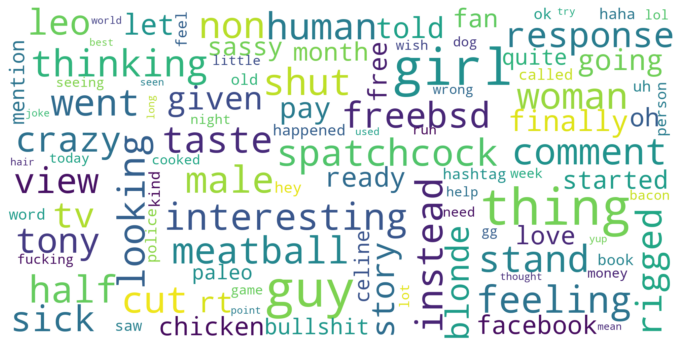

In [24]:
plt.figure(figsize=(10,6)) 
topic_words = ' '.join([cv.get_feature_names()[i] for i in topic.argsort()[-150:]])

word_cloud = WordCloud(background_color='white',
                           max_words=100,
                           max_font_size=30,
                           scale=5,
                           random_state=1).generate(topic_words)

plt.imshow(word_cloud,interpolation="bilinear")
plt.tight_layout()
plt.axis("off")
plt.show()

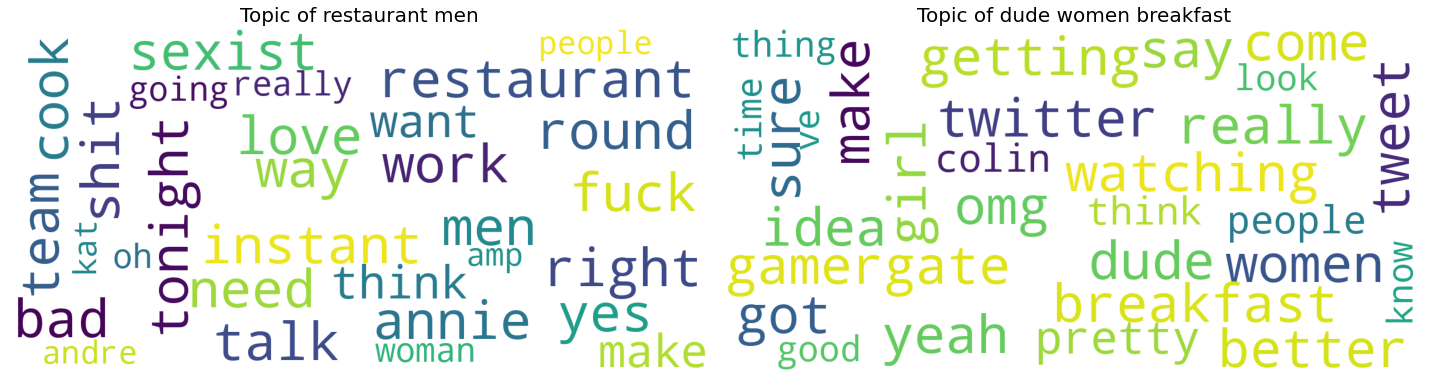

In [25]:
ncol=2
n_clust =2
nrows=ceil(n_clust/ncol)
fig, axeslist = plt.subplots(ncols=ncol,nrows=nrows, figsize=(20,20))
for index,topic in enumerate(LDA.components_):
    name = []
    topic_words = ' '.join([cv.get_feature_names()[i] for i in topic.argsort()[-30:]])
    word_cloud = WordCloud(background_color='white',
                           max_words=100,
                           max_font_size=30,
                           scale=3,
                           random_state=1).generate(topic_words)
    for ent in nlp(u' '.join([cv.get_feature_names()[i] for i in topic.argsort()[-30:]])).noun_chunks:
        name.append(ent.text)
    axeslist.ravel()[index].imshow(word_cloud)
    axeslist.ravel()[index].set_title(f'Topic of {name[0]}',fontsize=20)
    axeslist.ravel()[index].set_axis_off()
        
plt.tight_layout()
plt.show()

In [38]:
data = [clean_data(line) for line in text]
# data
data

["i'll contact k directly using social network.",
 "i'm sure middle school teacher think charming.",
 "yeah. i'm kind feeling like i'm doing, wsp ok. granular monitoring, redis would good.",
 'star chef pete evans say critic eat humble pie.',
 'turning particularly awful come dine me.',
 'quite symbiotic relationship. gg point targets, /baph/ doxxes terrorises, gg',
 'sexist then? four six team fourth instant restaurant all-female team.',
 'gamergate finally eating tail?',
 'ignore fools. embrace term "bitch". mean strength express opinions. "bitch"',
 'sunny today! went dog park hour.',
 'see gun control mental illness tragedy, million u see natural extension everyday experi',
 'blonde chick wearing hot pink dress!! lol',
 'kat andre going score higher anyway...',
 'really understand everybody seems okay that.',
 'somewhere. maybe? pink pullover, pink backpack?',
 'like seriously get one racist sexist fuckwad leadership position today',
 "referring 'we'?",
 'yeah, talk. send email rig

In [39]:
text

0       I'll contact KS directly using my social network.
1       I'm sure your middle school teachers think you...
2       yeah. i'm kind of feeling like for what i'm do...
3       star and chef Pete Evans says his critics will...
5       This is turning into a particularly awful Come...
                              ...                        
7853    but on the other hand, it sends a message. and...
7854                   Yes all men disappoint eventually.
7855                                             too late
7857    not sure yet, but I've heard good things from ...
7858    when someone uses my last name to introduce or...
Name: tweet text, Length: 5799, dtype: object

In [40]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

df['neg'] = text.apply(lambda x: sid.polarity_scores(x)['neg'])
df['pos'] = text.apply(lambda x: sid.polarity_scores(x)['pos'])
df['neu'] = text.apply(lambda x: sid.polarity_scores(x)['neu'])



In [41]:
tot = sum([sum(df['neg']), sum(df['pos'])])

In [42]:
df

,tweet id,annotation,tweet text,tweet user id,tweet user,retweet_user,neg,pos,neu
0,563459251025088512,2.0,@Skawtnyc @a_man_in_black @ChrisWarcraft I'll ...,13857342,randileeharper,[],0.000,0.000,1.000
1,469986918386528256,2.0,@LOTRQuotes69 I'm sure your middle school teac...,930620467,YesYoureSexist,[],0.000,0.433,0.567
2,564575620169216000,2.0,@cheeseplus yeah. i'm kind of feeling like for...,13857342,randileeharper,[],0.000,0.393,0.607
3,576227451342319616,2.0,#MKR star and chef Pete Evans says his critics...,9609622,perthnow,[],0.167,0.000,0.833
5,572328895711612928,2.0,This is turning into a particularly awful Come...,556661091,pwafork,[],0.268,0.000,0.732
...,...,...,...,...,...,...,...,...,...
7853,574408166575767553,2.0,"@athenahollow but on the other hand, it sends ...",1532819112,BlomquistTara,[],0.000,0.158,0.842
7854,522846267320184832,2.0,Yes all men disappoint eventually.,13857342,randileeharper,[],0.321,0.321,0.357
7855,575525729263304705,2.0,@sigje too late :P,39935935,olivewhippet,[],0.000,0.000,1.000
7857,573630339035193347,2.0,"@aninkyaffair not sure yet, but I've heard goo...",13857342,randileeharper,[],0.103,0.269,0.628


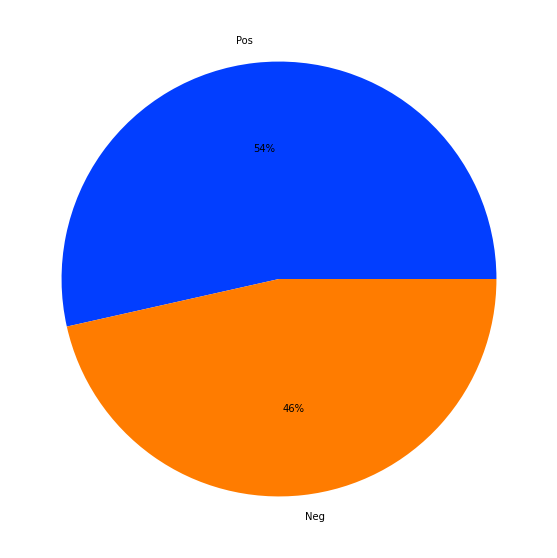

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
plt.figure(figsize=(12,10)) 
data = [sum(df['pos'])/tot * 100, sum(df['neg'])/tot * 100]
labels = ['Pos', 'Neg']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [31]:
#Import the modules
import text2emotion as te

#Call to the function
te.get_emotion(df['tweet text'][0])

{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0}

In [44]:
temp_emo = text.apply(lambda x:te.get_emotion(x))

In [45]:
emotion = pd.DataFrame()
emotion['Happy'] = list(temp_emo.apply(lambda x:x['Happy']))
emotion['Angry'] = list(temp_emo.apply(lambda x:x['Angry']))
emotion['Surprise'] = list(temp_emo.apply(lambda x:x['Surprise']))
emotion['Sad'] = list(temp_emo.apply(lambda x:x['Sad']))
emotion['Fear'] = list(temp_emo.apply(lambda x:x['Fear']))

tot = sum([sum(emotion['Happy']), sum(emotion['Angry']), sum(emotion['Surprise']), sum(emotion['Sad']), sum(emotion['Fear'])])

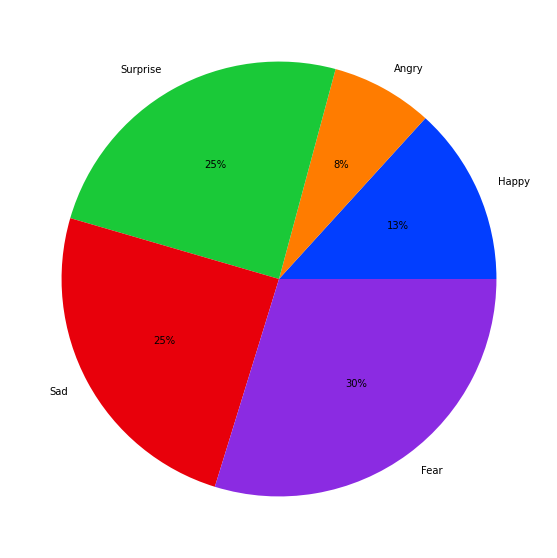

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
plt.figure(figsize=(12,10)) 
data = [sum(emotion['Happy'])/tot * 100, sum(emotion['Angry'])/tot * 100,
        sum(emotion['Surprise'])/tot * 100, sum(emotion['Sad'])/tot * 100,
        sum(emotion['Fear'])/tot * 100]
labels = ['Happy', 'Angry', 'Surprise', 'Sad', 'Fear']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()